Projet : Accident de la route
==============

## Etape 3 : Modélisation

### Import des données

In [2]:
# import des librairies
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import confusion_matrix,classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# import du dataset
df = pd.read_csv("dataset/dataset_final.csv")
df.head()

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday
0,1,1,1,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2,6,2
1,1,1,0,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,7,6,2
2,1,1,1,1,9,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,4,3,3
3,1,1,0,1,4,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,6,3,3
4,1,1,0,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,3,6,3


### Séparation des données

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["grav"], axis=1), df.grav, test_size=0.2)
print("Séparation des labels et targets :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Séparation des labels et targets : (365142, 34) (91286, 34) (365142,) (91286,)


In [5]:
# standardisation
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modélisation

Matrice de confusion :
 [[29877  8332]
 [11118 41959]]


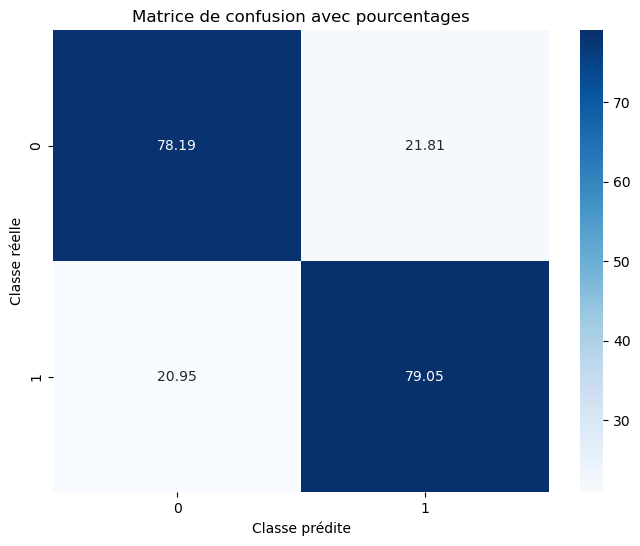

In [6]:
# model baseline
model = AdaBoostClassifier().fit(X_train_scaled, y_train)
y_pred_ada_1 = model.predict(X_test_scaled)

cm_ada_1 = confusion_matrix(y_test, y_pred_ada_1)
print("Matrice de confusion :\n", cm_ada_1)

row_sums_ada_1 = cm_ada_1.sum(axis = 1)
cm_percent_ada_1 = (cm_ada_1.T / row_sums_ada_1).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_ada_1, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show();

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleurs paramètres trouvés: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 800}
Meilleur score de validation croisée: 0.8127946304507304
Matrice de confusion :
 [[30331  7878]
 [11325 41752]]


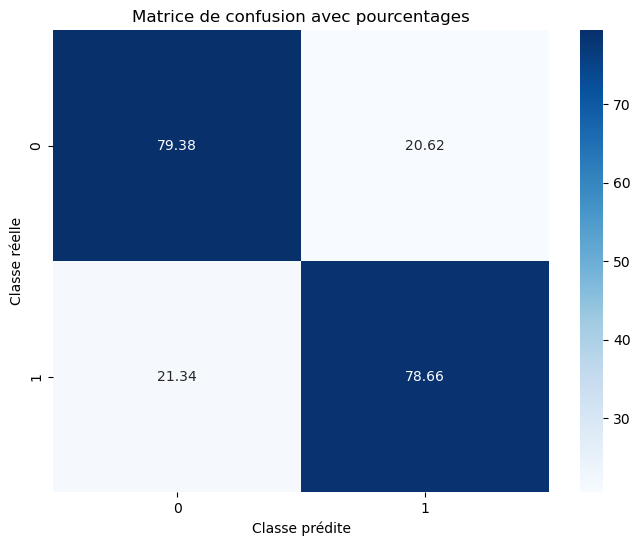

In [7]:
# model n°1

hp_ada = {
    'n_estimators': [600, 700, 800],        # Nombre de classificateurs faibles
    'learning_rate': [0.01, 0.1],     # Taux d'apprentissage : ajuste la contribution de chaque classificateur faible à la prédiction finale
    'algorithm': ['SAMME.R']      # Algorithme utilisé; 'SAMME.R' deprecied
}

dtc = DecisionTreeClassifier(random_state=42, max_depth=1)

gs_ada= GridSearchCV(estimator=AdaBoostClassifier(random_state=42, estimator=dtc),
                     param_grid=hp_ada,
                           cv = 5,  # Nombre de folds pour la validation croisée
                           verbose = 3, # Affiche le degré de détail des calculs
                           refit=True, # réentraine le modèle avec toutes les données
                           scoring="f1",
                           n_jobs = -1)  # Utiliser tous les coeurs du CPU

gs_ada.fit(X_train_scaled, y_train)

best_hp_ada = gs_ada.best_params_
best_score_ada = gs_ada.best_score_
best_estimator_ada = gs_ada.best_estimator_

print("Meilleurs paramètres trouvés:", best_hp_ada)
print("Meilleur score de validation croisée:", best_score_ada)

y_pred_ada = best_estimator_ada.predict(X_test_scaled)

cm_ada = confusion_matrix(y_test, y_pred_ada)
print("Matrice de confusion :\n", cm_ada)

row_sums_ada = cm_ada.sum(axis = 1)
cm_percent_ada = (cm_ada.T / row_sums_ada).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_ada, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show();

In [8]:
importances = best_estimator_ada.feature_importances_

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
27,obsm,0.30
29,manv,0.12
25,catv,0.11
21,col,0.05
28,choc,0.04
22,lat,0.04
5,locp,0.04
26,obs,0.04
1,catu,0.04
2,sexe,0.03


### Modélisation après recherche des meilleures variables

Séparation des labels et targets : (365142, 15) (91286, 15) (365142,) (91286,)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleurs paramètres trouvés: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 800}
Meilleur score de validation croisée: 0.8131944941406142
Matrice de confusion :
 [[30162  8206]
 [11326 41592]]


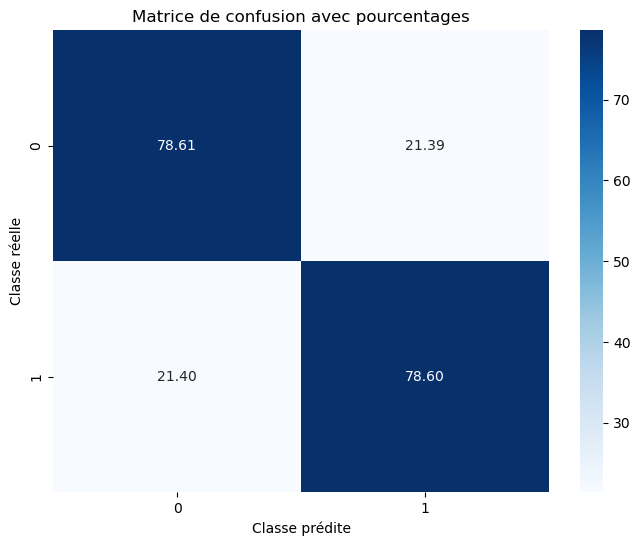

In [9]:
X = df.drop(['trajet','age_group', 'long', 'motor', 'vosp', 'lum', 'agg', 'com', 'situ','grav', 'infra', 'surf', 'plan', 'circ', 'atm', 'senc', 'int', 'prof', 'nbv', 'weekday'], axis=1)
y = df.grav

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Séparation des labels et targets :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# standardisation
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

hp_ada = {
    'n_estimators': [600, 700, 800],        # Nombre de classificateurs faibles
    'learning_rate': [0.01, 0.1],     # Taux d'apprentissage : ajuste la contribution de chaque classificateur faible à la prédiction finale
    'algorithm': ['SAMME.R']      # Algorithme utilisé; 'SAMME.R' deprecied
}

dtc = DecisionTreeClassifier(random_state=42, max_depth=1)

gs_ada= GridSearchCV(estimator=AdaBoostClassifier(random_state=42, estimator=dtc),
                     param_grid=hp_ada,
                           cv = 5,  # Nombre de folds pour la validation croisée
                           verbose = 3, # Affiche le degré de détail des calculs
                           refit=True, # réentraine le modèle avec toutes les données
                           scoring="f1",
                           n_jobs = -1)  # Utiliser tous les coeurs du CPU

gs_ada.fit(X_train_scaled, y_train)

best_hp_ada = gs_ada.best_params_
best_score_ada = gs_ada.best_score_
best_estimator_ada = gs_ada.best_estimator_

print("Meilleurs paramètres trouvés:", best_hp_ada)
print("Meilleur score de validation croisée:", best_score_ada)

y_pred_ada = best_estimator_ada.predict(X_test_scaled)

cm_ada = confusion_matrix(y_test, y_pred_ada)
print("Matrice de confusion :\n", cm_ada)

row_sums_ada = cm_ada.sum(axis = 1)
cm_percent_ada = (cm_ada.T / row_sums_ada).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_ada, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

### Sauvegarde du modèle

In [10]:
import joblib

# Sauvegarder le modèle
joblib.dump(best_estimator_ada, 'best_estimator_ada_model.joblib')

['best_estimator_ada_model.joblib']

### Analyse des résultats

In [11]:
# création d'un df pour ajouter les prédictions au dataset
df_filtered = df.iloc[:len(y_test)]  

df_filtered['pred_ada'] = y_pred_ada
df_filtered.head()

C:\Users\belmo\AppData\Local\Temp\ipykernel_12504\1544141892.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pred_ada'] = y_pred_ada


,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday,pred_ada
0,1,1,1,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2,6,2,1
1,1,1,0,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,7,6,2,1
2,1,1,1,1,9,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,4,3,3,0
3,1,1,0,1,4,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,6,3,3,0
4,1,1,0,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,3,6,3,1


In [12]:
# création d'un df qui affiche toutes les prédictions qui ne sont pas identiques au réel
df_mismatch = df_filtered[df_filtered['grav'] != df_filtered['pred_ada']]
df_mismatch.head()

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday,pred_ada
1,1,1,0,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,7,6,2,1
2,1,1,1,1,9,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,4,3,3,0
4,1,1,0,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,3,6,3,1
5,1,1,1,2,9,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,1,6,0,2,4,2,1,4,6,3,0
7,10,3,1,2,5,2,1,4,1,1,0,2,1,1,0,1,30,1,16102,2,3,8,6,45.69,-0.33,2,6,0,1,3,16,1,6,6,3,0


### Modèle AdaBoostClassifier

In [13]:
# Modele AdaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

In [14]:
# Créer et entraîner le modèle AdaBoost
ada_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_clf.fit(X_train, y_train)


# Prédire sur l'ensemble de test
y_pred = ada_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# Afficher les résultats
print(f"AdaBoost Accuracy: {accuracy:.2f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))
print("\nExactitude :")
print(accuracy_score(y_test, y_pred))


AdaBoost Accuracy: 0.79

Rapport de classification :
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     38368
           1       0.83      0.79      0.81     52918

    accuracy                           0.79     91286
   macro avg       0.78      0.78      0.78     91286
weighted avg       0.79      0.79      0.79     91286


Exactitude :
0.7859693709878842


### Modèle Perceptron

In [16]:
# Modèle Perceptron
from sklearn.linear_model import Perceptron
# perceptron
from sklearn.metrics import accuracy_score, classification_report
# Initialiser et entraîner le modèle Perceptron
perceptron_clf = Perceptron()
perceptron_clf.fit(X_train, y_train)

# Prédire les valeurs pour l'ensemble de test
y_pred = perceptron_clf.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Afficher les résultats
print(f"Perceptron Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

Perceptron Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69     38368
           1       0.78      0.76      0.77     52918

    accuracy                           0.73     91286
   macro avg       0.73      0.73      0.73     91286
weighted avg       0.73      0.73      0.73     91286



### Modèle ExtraTreesClassifier

In [17]:
# ExtraTreesClassifier
# Initialiser et entraîner le modèle ExtraTreesClassifier
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_clf.fit(X_train, y_train)
# Prédire les valeurs pour l'ensemble de test
y_pred = et_clf.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Afficher les résultats
print(f"ExtraTreesClassifier Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

ExtraTreesClassifier Accuracy: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73     38368
           1       0.81      0.81      0.81     52918

    accuracy                           0.78     91286
   macro avg       0.77      0.77      0.77     91286
weighted avg       0.78      0.78      0.78     91286



### Modèle DecisionTreeClassifier

In [41]:
# DecisionTreesClassifier
# Initialiser et entraîner le modèle DecisionTreesClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
# Prédire les valeurs pour l'ensemble de test
y_pred = dt_clf.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Afficher les résultats
print(f"ExtraTreesClassifier Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

ExtraTreesClassifier Accuracy: 0.74

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69     38368
           1       0.78      0.77      0.77     52918

    accuracy                           0.74     91286
   macro avg       0.73      0.73      0.73     91286
weighted avg       0.74      0.74      0.74     91286



### Modèle XGBClassifier

In [20]:
# XGBClassifier
from xgboost import XGBClassifier

# Initialiser et entraîner le modèle XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
# Prédire les valeurs pour l'ensemble de test
y_pred = xgb_clf.predict(X_test)
# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
# Afficher les résultats
print(f"XGBClassifier Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

XGBClassifier Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78     38368
           1       0.84      0.83      0.83     52918

    accuracy                           0.81     91286
   macro avg       0.80      0.81      0.80     91286
weighted avg       0.81      0.81      0.81     91286



### Modèle LGBMClassifier

In [22]:
# LGBMClassifier
from lightgbm import LGBMClassifier

# LightGBM : lightgbm.LGBMClassifier
# Initialiser et entraîner le modèle LightGBM
lig_clf = LGBMClassifier(use_label_encoder=False, eval_metric='logloss')
lig_clf.fit(X_train, y_train)
# Prédire les valeurs pour l'ensemble de test
y_pred = lig_clf.predict(X_test)
# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
# Afficher les résultats
print(f"LGBMClassifier Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)



LGBMClassifier Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77     38368
           1       0.84      0.83      0.83     52918

    accuracy                           0.81     91286
   macro avg       0.80      0.80      0.80     91286
weighted avg       0.81      0.81      0.81     91286



### Modèle KNeighborsClassifier

In [24]:
# KNeighborsClassifier

from sklearn.neighbors import KNeighborsClassifier
# Initialiser et entraîner le modèle KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)

# Prédire les valeurs pour l'ensemble de test
y_pred = knn_clf.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Afficher les résultats
print(f"KNeighborsClassifier Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

KNeighborsClassifier Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72     38368
           1       0.80      0.80      0.80     52918

    accuracy                           0.77     91286
   macro avg       0.76      0.76      0.76     91286
weighted avg       0.77      0.77      0.77     91286



### Modèle DummyClassifier

In [25]:
# DummyClassifier
from sklearn.dummy import DummyClassifier

# Initialiser et entraîner le DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# Prédire les valeurs pour l'ensemble de test
y_pred = dummy_clf.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"DummyClassifier Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

DummyClassifier Accuracy: 0.58

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     38368
           1       0.58      1.00      0.73     52918

    accuracy                           0.58     91286
   macro avg       0.29      0.50      0.37     91286
weighted avg       0.34      0.58      0.43     91286



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modèle LogisticRegression

In [26]:
# LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Prédire les valeurs pour l'ensemble de test
y_pred = log_reg.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Afficher les résultats
print(f"Logistic Regression Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.74

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69     38368
           1       0.78      0.76      0.77     52918

    accuracy                           0.74     91286
   macro avg       0.73      0.73      0.73     91286
weighted avg       0.74      0.74      0.74     91286



### Aperçu  de la performance relative des différents modèles de classification

In [27]:
models_list = [DummyClassifier, LogisticRegression, DecisionTreeClassifier, XGBClassifier,
               LGBMClassifier,KNeighborsClassifier, ExtraTreesClassifier, Perceptron, AdaBoostClassifier]


In [28]:
# Initialiser LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None,
                     predictions=True, classifiers=models_list)

# Entrainer et évaluer les modèles
models_train, predictions_train = clf.fit(X_train, X_test, y_train, y_test)
models_test, predictions_test = clf.fit(X_train, X_test, y_train, y_test)
# Afficher les résultats
print(models_list)

100%|██████████| 8/8 [07:43<00:00, 57.89s/it] 


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 8/8 [07:24<00:00, 55.55s/it] 

[<class 'sklearn.dummy.DummyClassifier'>, <class 'sklearn.linear_model._logistic.LogisticRegression'>, <class 'sklearn.tree._classes.DecisionTreeClassifier'>, <class 'xgboost.sklearn.XGBClassifier'>, <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>, <class 'sklearn.linear_model._perceptron.Perceptron'>, <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>]


In [29]:
models_train

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.81,0.81,0.81,0.81,3.98
AdaBoostClassifier,0.79,0.78,0.78,0.79,24.31
ExtraTreesClassifier,0.78,0.77,0.77,0.78,120.65
KNeighborsClassifier,0.78,0.77,0.77,0.78,300.31
DecisionTreeClassifier,0.74,0.73,0.73,0.74,10.79
LogisticRegression,0.73,0.73,0.73,0.73,1.03
Perceptron,0.69,0.68,0.68,0.69,1.58
DummyClassifier,0.58,0.50,0.50,0.43,0.47


### Cross Validation

In [30]:
from sklearn.metrics import confusion_matrix

In [38]:
# Cross validation - KNeighborsClassifier - KFold = 5
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score


# Initialisation du modèle
model = KNeighborsClassifier()

# Configuration de la validation croisée K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Évaluation du modèle avec la validation croisée
scores = cross_val_score(model, X, y, cv=kf)
std_score = np.std(scores)    # Écart-type des scores
print("Scores de validation croisée : ", scores)
print("Score moyen : ", scores.mean())
print("Ecart type  : ", std_score)

Scores de validation croisée :  [0.77271433 0.77410556 0.7758802  0.77747713 0.77744427]
Score moyen :  0.7755242970913394
Ecart type  :  0.0018727132593776411


In [31]:

# Cross validation - XGBClassifier - KFold = 5
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score


# Initialisation du modèle
model = XGBClassifier()

# Configuration de la validation croisée K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Évaluation du modèle avec la validation croisée
scores = cross_val_score(model, X, y, cv=kf)
std_score = np.std(scores)    # Écart-type des scores
print("Scores de validation croisée : ", scores)
print("Score moyen : ", scores.mean())
print("Ecart type  : ", std_score)

Scores de validation croisée :  [0.80976272 0.8086344  0.80788949 0.80954155 0.81061511]
Score moyen :  0.8092886535868639
Ecart type  :  0.0009416876404237049


In [34]:
# Cross validation - ExtraTreesClassifier - KFold = 4
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score


# Initialisation du modèle
model = ExtraTreesClassifier()

# Configuration de la validation croisée K-Fold
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Évaluation du modèle avec la validation croisée
scores = cross_val_score(model, X, y, cv=kf)
std_score = np.std(scores)    # Écart-type des scores
print("Scores de validation croisée : ", scores)
print("Score moyen : ", scores.mean()) # Moyenne 
print("Ecart type  : ", std_score)


Scores de validation croisée :  [0.777621   0.77689362 0.77789268 0.78072336]
Score moyen :  0.7782826645166379
Ecart type  :  0.0014557050905332205


In [35]:
# Cross validation - AdaBoostClassifier
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score


# Initialisation du modèle
model = AdaBoostClassifier()

# Configuration de la validation croisée K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Évaluation du modèle avec la validation croisée
scores = cross_val_score(model, X, y, cv=kf)
std_score = np.std(scores)    # Écart-type des scores
print("Scores de validation croisée : ", scores)
print("Score moyen : ", scores.mean())
print("Ecart type moyen : ", std_score)

Scores de validation croisée :  [0.78783165 0.78836842 0.78789738 0.78666813 0.78867284]
Score moyen :  0.787887683414686
Ecart type moyen :  0.0006838318929365241


### Stockage les résultats de la Cross Validation pour chaque modèle et dans une liste

In [37]:
from sklearn.model_selection import cross_validate

In [47]:
# Définir les modèles à tester
models = {
    'AdaBoostClassifier': AdaBoostClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'XGBClassifier': XGBClassifier(),
    'LogisticRegression':LogisticRegression(),
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier()
   }


# Liste pour stocker les résultats
results = []

# Effectuer la validation croisée pour chaque modèle
for name, model in models.items():
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    # cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    results.append({
        'Model': name,
        'Mean Accuracy': np.mean(cv_results['test_accuracy']),
        'Std Accuracy': np.std(cv_results['test_accuracy']),
        'Mean Precision': np.mean(cv_results['test_precision_macro']),
        'Std Precision': np.std(cv_results['test_precision_macro']),
        'Mean Recall': np.mean(cv_results['test_recall_macro']),
        'Std Recall': np.std(cv_results['test_recall_macro']),
        'Mean F1-score': np.mean(cv_results['test_f1_macro']),
        'Std F1-score': np.std(cv_results['test_f1_macro'])
    })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)
# Afficher le résultat
print(results_df)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

                    Model  Mean Accuracy  Std Accuracy  Mean Precision  \
0      AdaBoostClassifier           0.79          0.00            0.78   
1    ExtraTreesClassifier           0.78          0.00            0.77   
2           XGBClassifier           0.81          0.00            0.80   
3      LogisticRegression           0.74          0.00            0.73   
4    KNeighborsClassifier           0.77          0.00            0.77   
5  DecisionTreeClassifier           0.74          0.00            0.73   

   Std Precision  Mean Recall  Std Recall  Mean F1-score  Std F1-score  
0           0.00         0.79        0.00           0.78          0.00  
1           0.00         0.77        0.00           0.77          0.00  
2           0.00         0.80        0.00           0.80          0.00  
3           0.00         0.73        0.00           0.73          0.00  
4           0.00         0.77        0.00           0.77          0.00  
5           0.00         0.73        0.00  

In [48]:
results_df

,Model,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall,Mean F1-score,Std F1-score
0,AdaBoostClassifier,0.79,0.00,0.78,0.00,0.79,0.00,0.78,0.00
1,ExtraTreesClassifier,0.78,0.00,0.77,0.00,0.77,0.00,0.77,0.00
2,XGBClassifier,0.81,0.00,0.80,0.00,0.80,0.00,0.80,0.00
3,LogisticRegression,0.74,0.00,0.73,0.00,0.73,0.00,0.73,0.00
4,KNeighborsClassifier,0.77,0.00,0.77,0.00,0.77,0.00,0.77,0.00
5,DecisionTreeClassifier,0.74,0.00,0.73,0.00,0.73,0.00,0.73,0.00
